In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import copy

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set to {SEED}.")

Random seed set to 42.


In [ ]:
EPOCHS = 100
BATCH_SIZE = 32
LR = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [ ]:
cancer_data = load_breast_cancer()
X = cancer_data.data
y = cancer_data.target

print(f"Data loaded. Features shape: {X.shape}, Target shape: {y.shape}")
print(f"Class names: {cancer_data.target_names}") # 0: malignant, 1: benign
print(f"Class distribution: {np.bincount(y)}")

Data loaded. Features shape: (569, 30), Target shape: (569,)
Class names: ['malignant' 'benign']
Class distribution: [212 357]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features scaled using StandardScaler.")

Features scaled using StandardScaler.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Data split complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Testing labels distribution: {np.bincount(y_test)}")

Data split complete.
Training samples: 455
Testing samples: 114
Training labels distribution: [170 285]
Testing labels distribution: [42 72]


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("Data converted to PyTorch tensors.")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")

Data converted to PyTorch tensors.
X_train_tensor shape: torch.Size([455, 30])
y_train_tensor shape: torch.Size([455, 1]), dtype: torch.float32


In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with batch size {BATCH_SIZE}.")

DataLoaders created with batch size 32.


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Returns raw logits
        return self.linear(x)

# Get input dimension from the data
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)

print("Model architecture (Logistic Regression):")
print(model)

Model architecture (Logistic Regression):
LogisticRegressionModel(
  (linear): Linear(in_features=30, out_features=1, bias=True)
)


In [ ]:
model = LogisticRegressionModel(input_dim).to(device)

# Loss function: BCEWithLogitsLoss
# This loss combines a Sigmoid layer and the Binary Cross Entropy Loss
# in one class. It's more numerically stable than a separate Sigmoid + BCELoss.
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Model, Loss Function (BCEWithLogitsLoss), and Optimizer (Adam) initialized.")
print(f"Model moved to {device}.")

Model, Loss Function (BCEWithLogitsLoss), and Optimizer (Adam) initialized.
Model moved to cpu.


In [ ]:
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_weights = None

print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Zero gradients
        optimizer.zero_grad()

        # 2. Forward pass (get logits)
        outputs = model(inputs)

        # 3. Calculate loss
        loss = criterion(outputs, labels)

        # 4. Backward pass
        loss.backward()

        # 5. Update weights
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)

    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # Save the best model
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        best_model_weights = copy.deepcopy(model.state_dict())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}")

print("Training finished.")

# Load the best model weights
model.load_state_dict(best_model_weights)
print(f"Best model weights loaded (Test Loss: {best_test_loss:.4f})")

Starting training for 100 epochs...
Epoch 10/100 | Train Loss: 0.3663 | Test Loss: 0.3723
Epoch 20/100 | Train Loss: 0.2319 | Test Loss: 0.2537
Epoch 30/100 | Train Loss: 0.1760 | Test Loss: 0.2025
Epoch 40/100 | Train Loss: 0.1458 | Test Loss: 0.1738
Epoch 50/100 | Train Loss: 0.1266 | Test Loss: 0.1553
Epoch 60/100 | Train Loss: 0.1136 | Test Loss: 0.1423
Epoch 70/100 | Train Loss: 0.1041 | Test Loss: 0.1327
Epoch 80/100 | Train Loss: 0.0969 | Test Loss: 0.1254
Epoch 90/100 | Train Loss: 0.0913 | Test Loss: 0.1198
Epoch 100/100 | Train Loss: 0.0868 | Test Loss: 0.1153
Training finished.
Best model weights loaded (Test Loss: 0.1153)


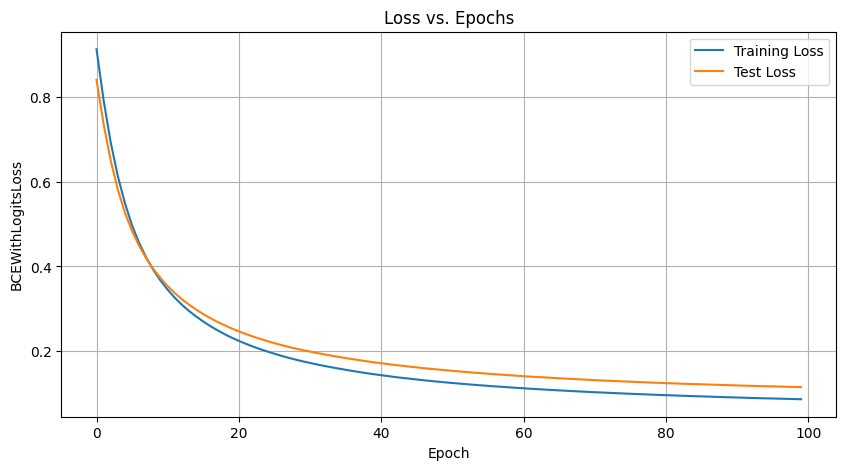

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('BCEWithLogitsLoss')
plt.legend()
plt.grid(True)
plt.show()


Final Model Evaluation on Test Set:
Accuracy: 98.25%

Confusion Matrix:
[[41  1]
 [ 1 71]]
(Row: True, Col: Predicted)


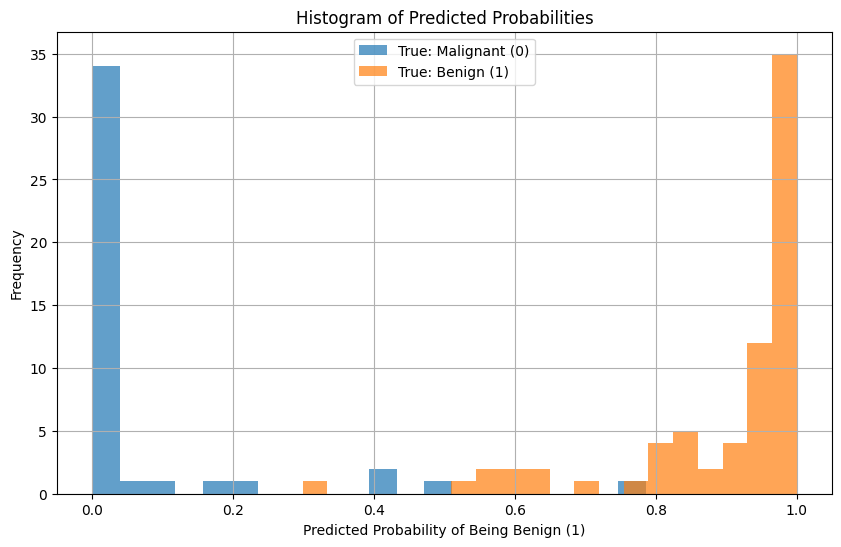

In [ ]:
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get raw logits
        outputs = model(inputs)

        # Convert logits to probabilities
        probs = torch.sigmoid(outputs)

        # Convert probabilities to binary predictions (0 or 1)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Flatten the lists
all_labels = np.array(all_labels).flatten()
all_preds = np.array(all_preds).flatten()
all_probs = np.array(all_probs).flatten()

# Calculate final accuracy
final_accuracy = accuracy_score(all_labels, all_preds)

print(f"\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {final_accuracy * 100:.2f}%")

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print(f"(Row: True, Col: Predicted)")

# Plot (ii): Histogram of Predicted Probabilities
plt.figure(figsize=(10, 6))
plt.hist(all_probs[all_labels == 0], bins=20, alpha=0.7, label='True: Malignant (0)')
plt.hist(all_probs[all_labels == 1], bins=20, alpha=0.7, label='True: Benign (1)')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Being Benign (1)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
MODEL_PATH = 'breast_cancer_model.pth'
torch.save(model.state_dict(), MODEL_PATH)

print(f"\nModel state dictionary saved to {MODEL_PATH}")


Model state dictionary saved to breast_cancer_model.pth
